# Data organizers: proof of concept

In [1]:
import arviz as az
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
idata = az.load_arviz_data("rugby")
post = az.extract(idata)

## current xarray plotting

it is mostly also ax based like ArviZ

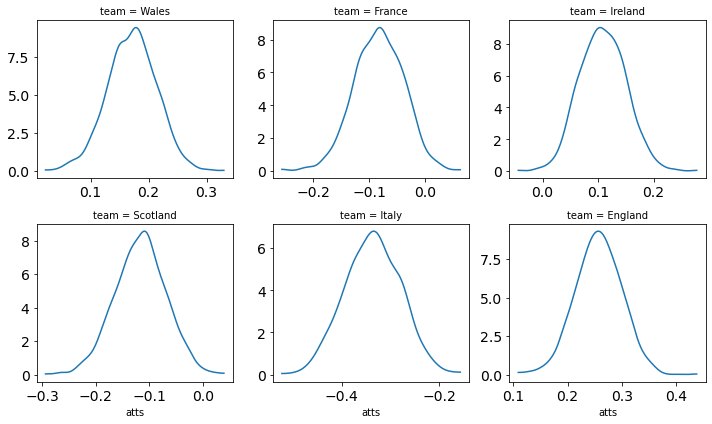

In [3]:
fg = xr.plot.FacetGrid(post, col="team", col_wrap=3, sharex=False, sharey=False)
fg.map(az.plot_dist, "atts")

plot_dist already works on the current axes if available and has no loopint inside it, it works on the provided values straight away.

We can also use this with other functions, but it is very far from ideal:

In [4]:
def plot_posterior_noax(*args, **kwargs):
    ax = plt.gca()
    az.plot_posterior(*args, ax=ax, **kwargs)

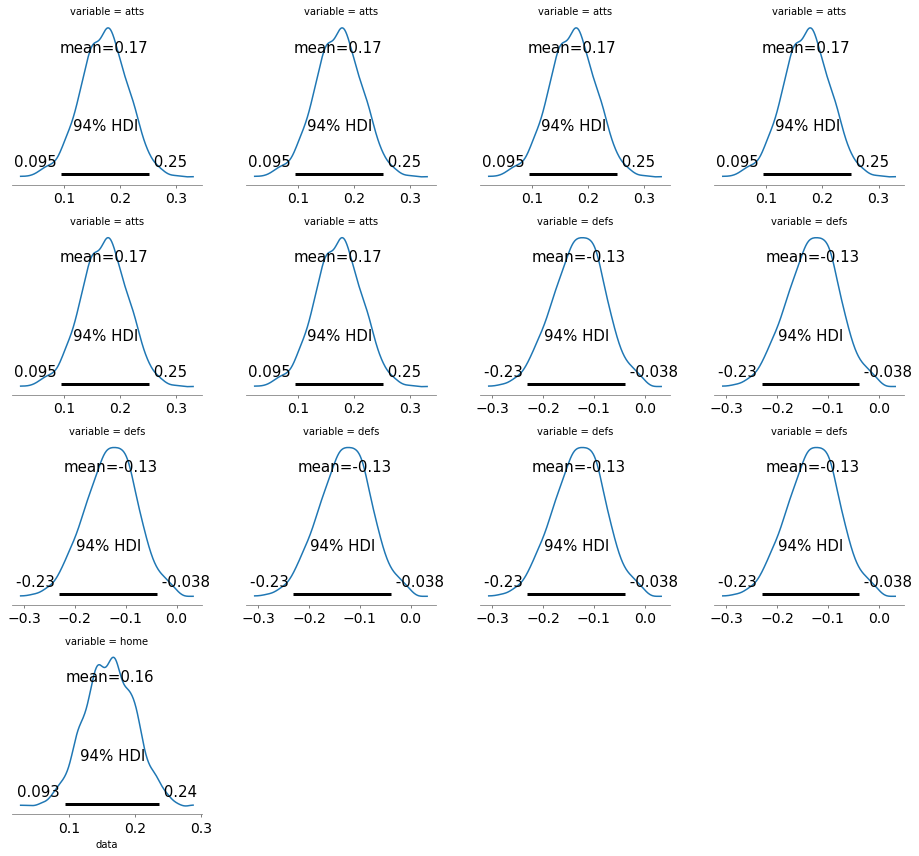

In [5]:
post = az.extract(idata, combined=False)
fg = xr.plot.FacetGrid(
    post[["atts", "defs", "home"]].to_stacked_array("param", sample_dims=["chain", "draw"], name="data").to_dataset(),
    col="variable", 
    col_wrap=4, 
    sharex=False, 
    sharey=False
)
fg.map(plot_posterior_noax, "data")

## draft proposed extensions

In [6]:
from arviz.plots.plot_utils import default_grid
from arviz.plots.backends.matplotlib import create_axes_grid
from arviz.sel_utils import xarray_sel_iter

from matplotlib.axes import Axes

def sel_subset(sel, present_dims):
    return {key: value for key, value in sel.items() if key in present_dims}

class PlotCollectionWrap:
    def __init__(
        self,
        data,
        aes=None,
        cols=None,
        col_wrap=4,
        subplot_kws=None,
        **kwargs
    ):

        self.data = data
        if subplot_kws is None:
            subplot_kws = {}
        plots_raw_shape = [len(data[col]) for col in cols]
        n_plots = np.prod(plots_raw_shape)
        n_rows, n_cols = default_grid(n_plots, max_cols=col_wrap)
        fig, ax_ary = create_axes_grid(n_plots, n_rows, n_cols, backend_kwargs=subplot_kws)
        plots_table_shape = ax_ary.shape
        self.ds = xr.Dataset(
            {"chart": fig, "plot": (cols, ax_ary.flatten().reshape(plots_raw_shape))},
            coords = {col: data[col] for col in cols}
        )

        if aes is None:
            aes = {}

        for aes_key, dims in aes.items():
            aes_raw_shape = [len(data[dim]) for dim in dims]
            n_aes = np.prod(aes_raw_shape)
            aes_vals = kwargs.get(aes_key, [None])
            n_aes_vals = len(aes_vals)
            if n_aes_vals > n_aes:
                aes_vals = aes_vals[:n_aes]
            elif n_aes_vals < n_aes:
                aes_vals = np.tile(aes_vals, (n_aes // n_aes_vals) + 1)[:n_aes]
            self.ds[aes_key] = xr.DataArray(
                np.array(aes_vals).reshape(aes_raw_shape), 
                dims=dims
            )
        self.aes = aes
        self.base_loop_dims = set(cols)
        self.artists = xr.Dataset()

    def subset_ds(self, var_name, sel):
        out = self.ds[var_name].sel(sel_subset(sel, self.ds[var_name].dims))
        return out.item()

    def map(self, fun, fun_label=None, *, ignore_aes=frozenset(), converter=None, store_artist=True, **kwargs):
        aes = [aes_key for aes_key in self.aes.keys() if aes_key not in ignore_aes]
        aes_dims = [dim for sublist in list(self.aes.values()) for dim in sublist]
        all_loop_dims = self.base_loop_dims.union(aes_dims)
        plotters = xarray_sel_iter(
            self.data, 
            skip_dims={dim for dim in self.data.dims if dim not in all_loop_dims}
        )
        artist_dims = [dim for dim in self.data.dims if dim in all_loop_dims]
        artist_shape = [len(self.data[dim]) for dim in artist_dims]

        if fun_label is None:
            fun_label = fun.__name__
        
        if store_artist:
            self.ds[fun_label] = xr.DataArray(
                np.empty(artist_shape ,dtype=object), 
                dims=artist_dims,
                coords={dim: self.data[dim] for dim in artist_dims}
            )
        for var_name, sel, isel in plotters:
            da = self.data.sel(sel)
            if converter:
                da = converter(da)
            ax = self.subset_ds("plot", sel)
            aes_kwargs = {}
            for aes_key in aes:
                dims = self.aes[aes_key]
                aes_kwargs[aes_key] = self.subset_ds(aes_key, sel)
            
            aux_artist = fun(da, ax=ax, **{**kwargs, **aes_kwargs})
            if store_artist:
                self.ds[fun_label].loc[sel] = aux_artist

    def add_legend(self, aes, artist, **kwargs):
        pass

In [7]:
az.kde

<function arviz.stats.density_utils.kde(x, circular=False, **kwargs)>

In [8]:
def kde_artist(values, **kwargs):
    grid, pdf = az.kde(np.array(values).flatten())
    ax = kwargs.pop("ax")
    return ax.plot(grid, pdf, **kwargs)[0]

### Base example: plot kdes for each of the 6 teams

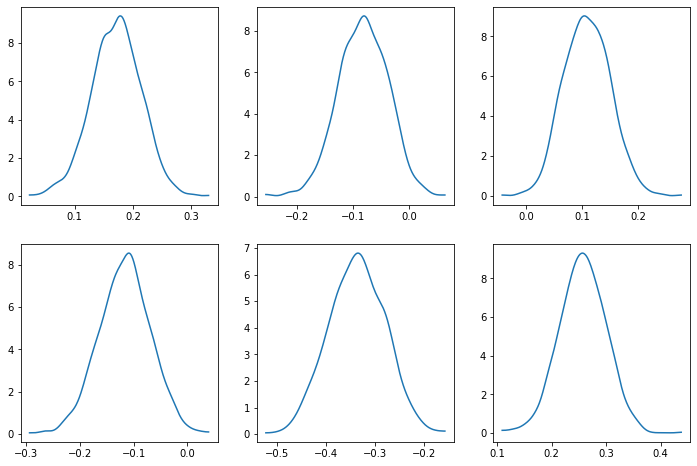

In [9]:
pc = PlotCollectionWrap(
    post["atts"], 
    cols=["team"], 
    subplot_kws={"figsize": (12, 8)}
)
pc.map(kde_artist, "kde")

### Add aesthetics: plot kdes for each team in different subplots, overlaying the different chains with different colors.

Note: not all plots will support all aesthetics.

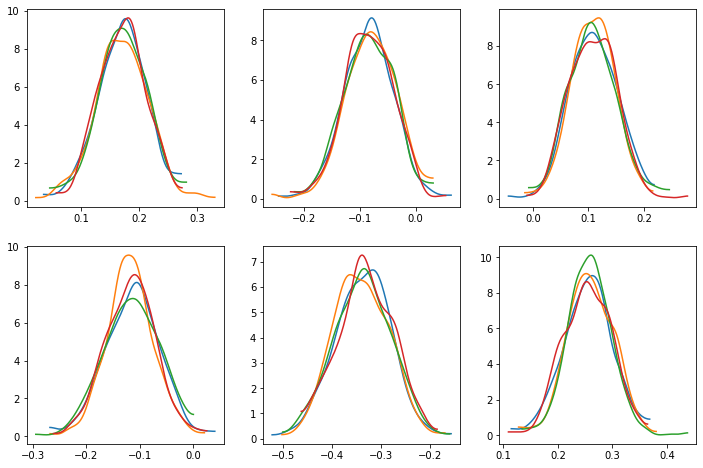

In [10]:
pc = PlotCollectionWrap(
    post["atts"], 
    cols=["team"], 
    aes={"color": ["chain"]}, 
    color=[f"C{i}" for i in range(4)],
    subplot_kws={"figsize": (12, 8)}
)
pc.map(kde_artist, "kde")

The figure (chart), axes (plot), generated artists (name given by user) and aesthetics mappings are stored in an xarray dataset:

In [11]:
pc.ds

<xarray.Dataset>
Dimensions:  (team: 6, chain: 4)
Coordinates:
  * team     (team) object 'Wales' 'France' 'Ireland' ... 'Italy' 'England'
  * chain    (chain) int64 0 1 2 3
Data variables:
    chart    object Figure(864x576)
    plot     (team) object AxesSubplot(0.125,0.536818;0.227941x0.343182) ... ...
    color    (chain) <U2 'C0' 'C1' 'C2' 'C3'
    kde      (chain, team) object Line2D(_child0) ... Line2D(_child3)

### Multiple aesthetics for the same dimension

We can set multiple asethetics to the same dimension, and both will be updated in sync in all plots:

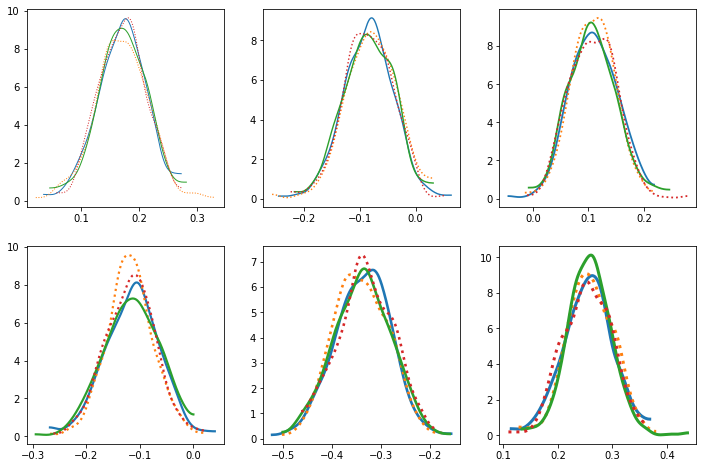

In [12]:
pc = PlotCollectionWrap(
    post["atts"], 
    cols=["team"], 
    aes={"color": ["chain"], "ls": ["chain"], "lw": ["team"]}, 
    color=[f"C{i}" for i in range(4)],
    ls=["-", ":"],
    lw=np.linspace(1, 3, 6),
    subplot_kws={"figsize": (12, 8)}
)
pc.map(kde_artist)

### Easy access to all plots elements

And as we have stored all the plotting related data, including artists in the `.ds` attribute, we can select artists from the plot and modify them _with label based indexing_. Here we can make the line for the Italy team and 3rd chain have diamonds as markers after plotting, with size 10 and show markers only once every 50 datapoints.

Note: I'd also like to add an extra coordinate, `grid` or something of the sort, that can be used to select axes
by their position in the subplot grid.

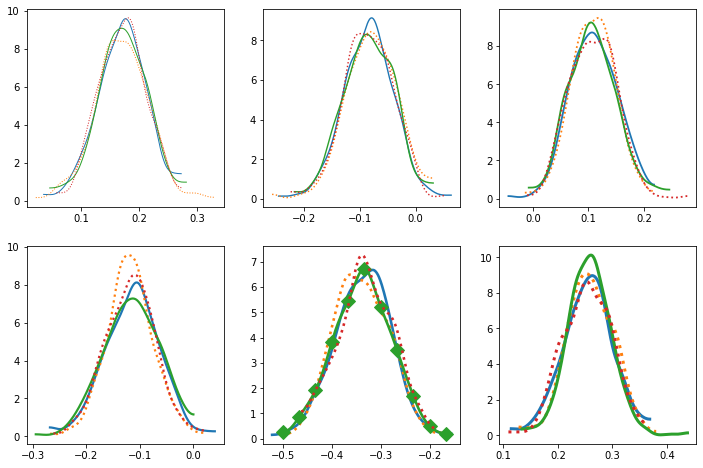

In [13]:
pc = PlotCollectionWrap(
    post["atts"], 
    cols=["team"], 
    aes={"color": ["chain"], "ls": ["chain"], "lw": ["team"]}, 
    color=[f"C{i}" for i in range(4)],
    ls=["-", ":"],
    lw=np.linspace(1, 3, 6),
    subplot_kws={"figsize": (12, 8)}
)
pc.map(kde_artist, "kde")
pc.ds["kde"].sel(team="Italy", chain=2).item().set(marker="D", markersize=10, markevery=50);

And unlike xarray facetting, all asethetics and facetting variables take lists of dimensions, not single dimensions

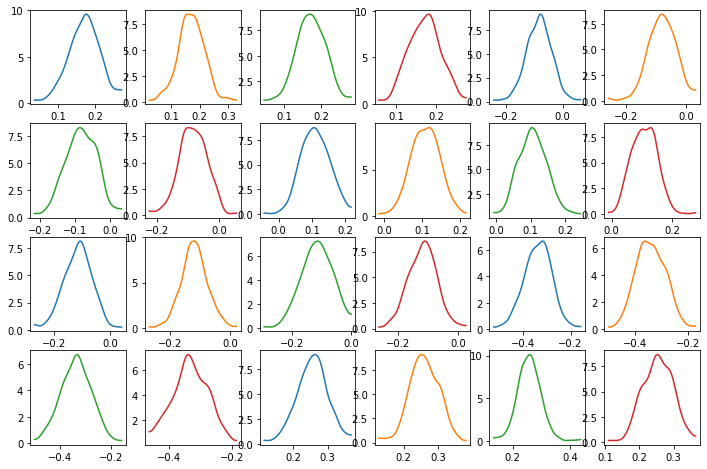

In [14]:
pc = PlotCollectionWrap(
    post["atts"], 
    cols=["team", "chain"],
    col_wrap=6,
    aes={"color": ["chain"]}, 
    color=[f"C{i}" for i in range(4)],
    subplot_kws={"figsize": (12, 8)}
)
pc.map(kde_artist)

the `plot` variable contines to have both team and chain dimensions, that do not match the grid ones. 

In [15]:
pc.ds

<xarray.Dataset>
Dimensions:     (team: 6, chain: 4)
Coordinates:
  * team        (team) object 'Wales' 'France' 'Ireland' ... 'Italy' 'England'
  * chain       (chain) int64 0 1 2 3
Data variables:
    chart       object Figure(864x576)
    plot        (team, chain) object AxesSubplot(0.125,0.71587;0.110714x0.164...
    color       (chain) <U2 'C0' 'C1' 'C2' 'C3'
    kde_artist  (chain, team) object Line2D(_child0) ... Line2D(_child0)

## Mimic existing ArviZ function

In [16]:
def interval_artist(values, **kwargs):
    int_func = kwargs.pop("int_func", az.hdi)
    interval = int_func(np.array(values).flatten())
    ax = kwargs.pop("ax")
    return ax.plot(interval, [0, 0], **kwargs)[0]

def point_artist(values, **kwargs):
    point_func = kwargs.pop("point_func", np.mean)
    point = point_func(np.array(values).flatten())
    ax = kwargs.pop("ax")
    return ax.plot(point, 0, **kwargs)[0]

def point_label_artist(values, **kwargs):
    point_func = kwargs.pop("point_func", np.mean)
    point_label = kwargs.pop("point_label", point_func.__name__)
    values = np.array(values).flatten()
    point = point_func(values)
    _, pdf = az.kde(values)
    top = np.max(pdf)
    
    ax = kwargs.pop("ax")
    return ax.text(point, .05 * top, f"{point:.2f} {point_label}", **kwargs)

def remove_left_axis(values, **kwargs):
    ax = kwargs.pop("ax")
    ax.get_yaxis().set_visible(False)
    ax.spines['left'].set_visible(False)

In [17]:
def plot_posterior(da, plot_collection=None):
    if plot_collection is None:
        plot_collection = PlotCollectionWrap(da, cols=[dim for dim in da.dims if dim not in {"chain", "draw"}])
    
    plot_collection.map(kde_artist, "kde")
    plot_collection.map(interval_artist, "interval", color="grey")    
    plot_collection.map(point_artist, "point_estimate", color="C0", ms="5", marker="o")
    plot_collection.map(point_label_artist, "point_label", color="C0", va="bottom", ha="center")
    plot_collection.map(remove_left_axis, store_artist=False)
    return plot_collection

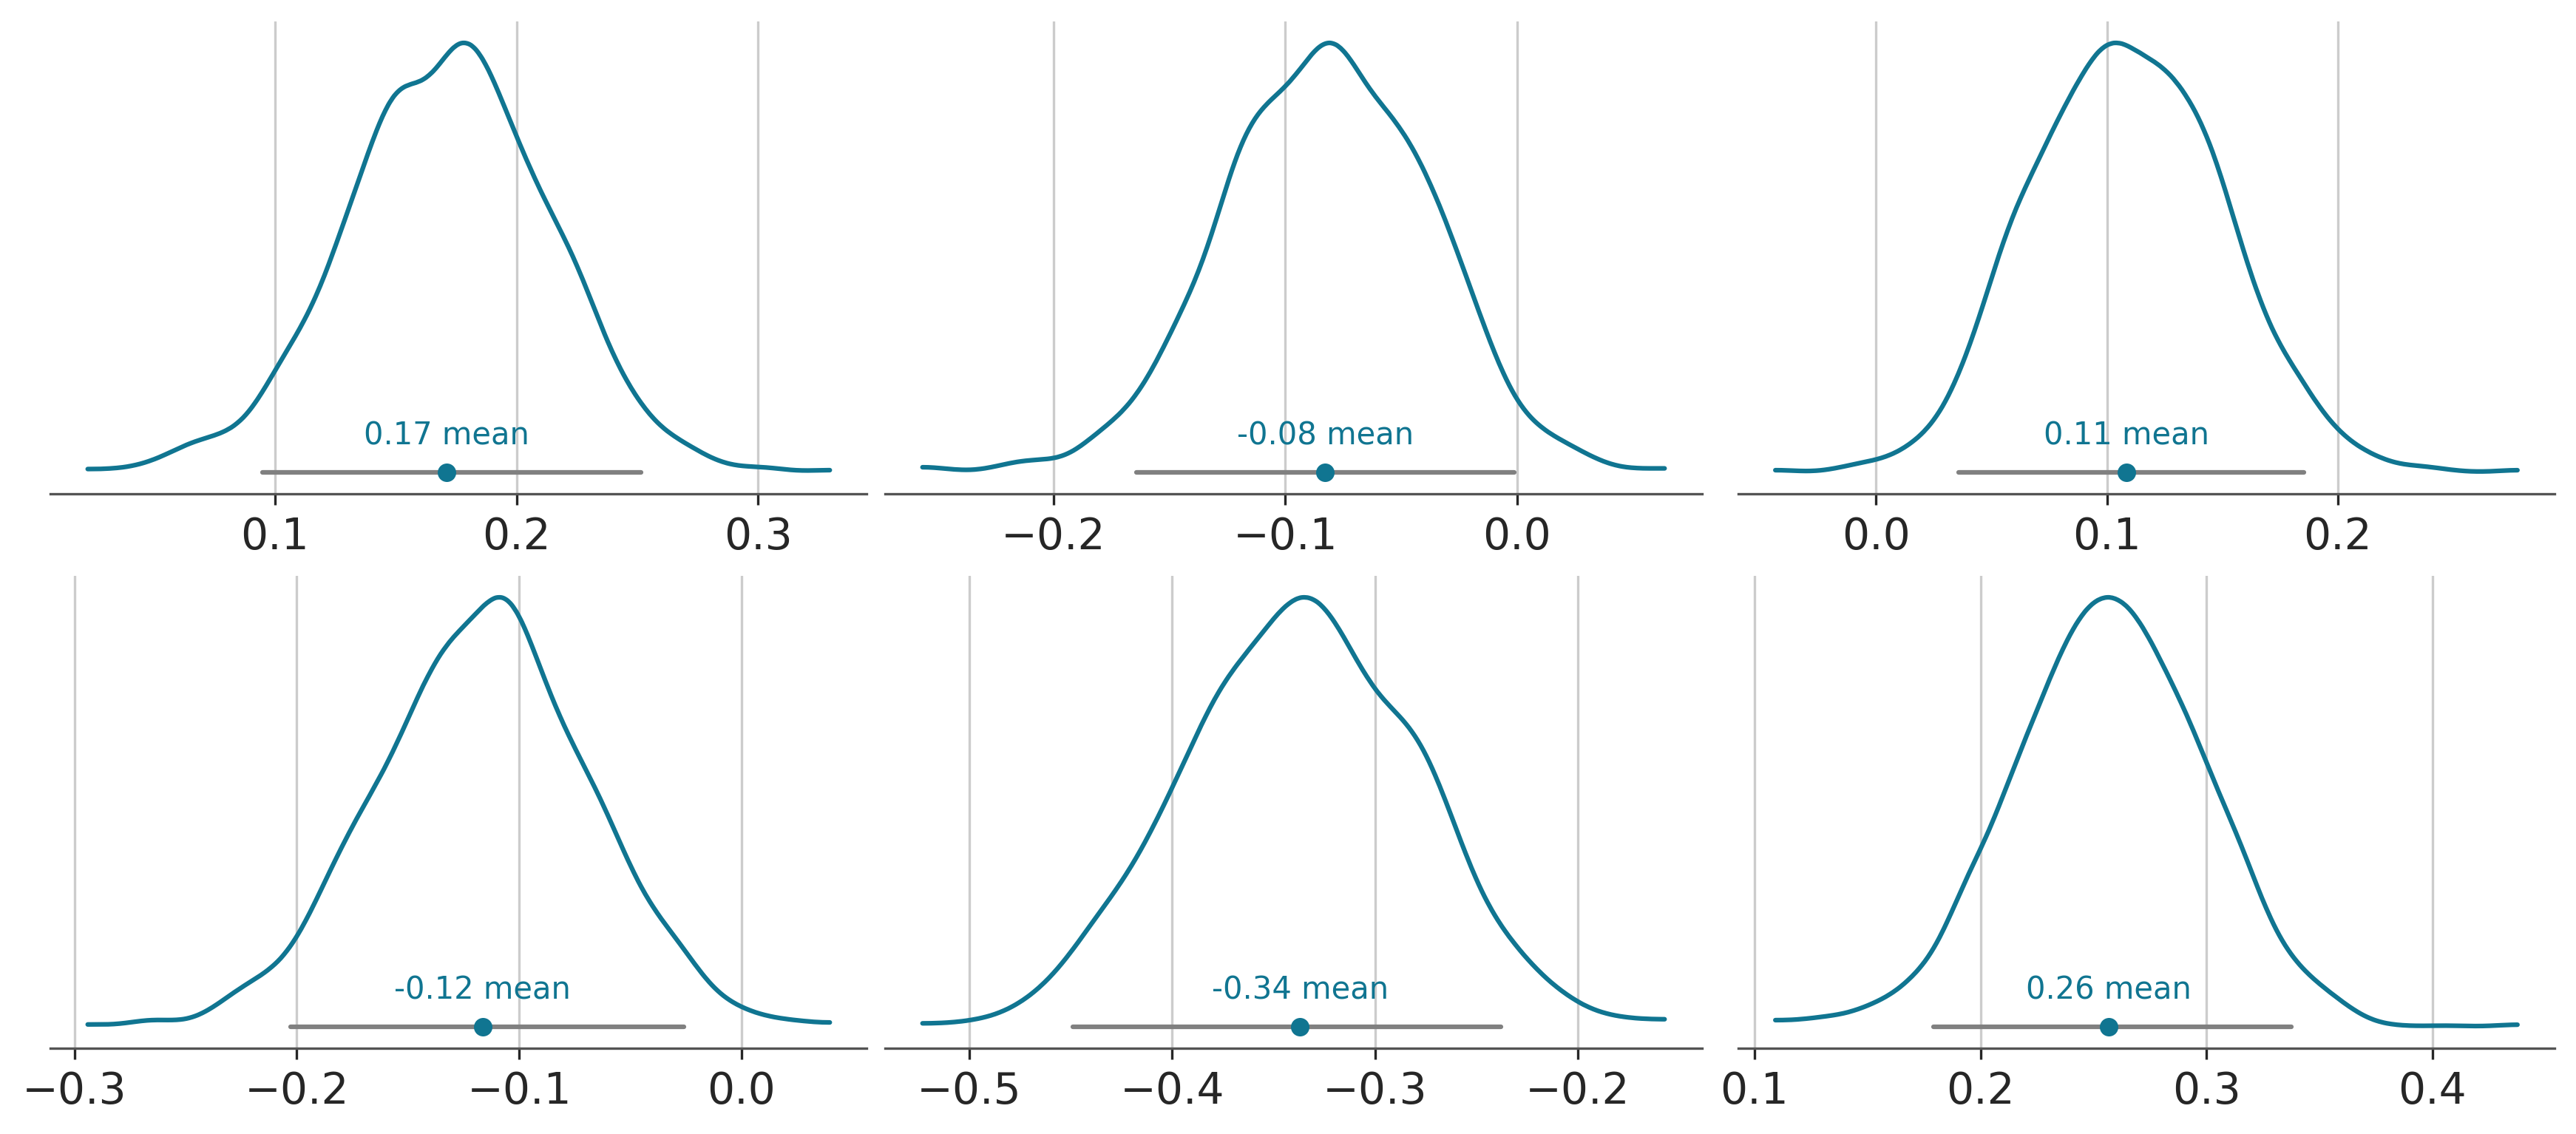

In [18]:
az.style.use("arviz-doc")
pc = plot_posterior(post["atts"])

In [19]:
pc.ds

<xarray.Dataset>
Dimensions:         (team: 6)
Coordinates:
  * team            (team) object 'Wales' 'France' ... 'Italy' 'England'
Data variables:
    chart           object Figure(3450x1500)
    plot            (team) object AxesSubplot(0.0147692,0.565778;0.320011x0.4...
    kde             (team) object Line2D(_child0) ... Line2D(_child0)
    interval        (team) object Line2D(_child1) ... Line2D(_child1)
    point_estimate  (team) object Line2D(_child2) ... Line2D(_child2)
    point_label     (team) object Text(0.17110852459382564, 0.470849748773512...

Labeling and legends and so on will come soon.